# User parameteres

In [1]:
TRIG_XDMF_PATH = "data/plume.xdmf"         # cell mesh (Grid)
FACETS_XDMF_PATH = "data/plume_mt.xdmf"    # facet tags (Grid)
OUTPUT_XDMF_PATH_WIRE = "data/abs/wire_temperature.xdmf" # output file for wire temperature
OUTPUT_XDMF_PATH_TEMP = "data/abs/temperature.xdmf" # output file for wire temperature
OUTPUT_XDMF_PATH_AIR_T = "data/abs/air_temperature.xdmf" # output file for wire temperature
OUTPUT_XDMF_PATH_AIR_P = "data/abs/air_pressure.xdmf" # output file for wire temperature
OUTPUT_XDMF_PATH_AIR_V = "data/abs/air_velocity.xdmf" # output file for wire temperature
OUTPUT_XDMF_PATH_AIR_PVT = "data/abs/air_pvt.xdmf" # output file for wire temperature
MESH_NAME = "Grid"                              # XDMF mesh name used when writing
GEOM_FILE = "data/geom.geo"                          # Gmsh geometry file
MSH_FILE = "data/plume.msh"                # Gmsh mesh file
ELEM = "triangle"                               # element type

WIRE_TAG = 10                                   # wire's cell tag id
AIR_TAG = 11                                    # air's cell tag id
SYMMETRY_AIR_TAG = 100                          # wire/air interface facet tag id 
OUTER_AIR_TAG = 101                             # wire/air interface facet tag id 
INTERFACE_TAG = 102                             # wire/air interface facet tag id 
PRINT_TAG_SUMMARY = True                        # print summary after reading mesh
UNIFORM_Q = True                                # use uniform heat generation

# Material and model params (wire)
k_wire = 16.0                                   # W/(m·K)  thermal conductivity
h_conv = 15.0                                   # W/(m²·K) effective convection at wire boundary
q_wire = 9.75                                       # W/m³ heat generation

k_air = 0.0257                                  # W/(m·K)  thermal conductivity
rho_air = 1.1614                                # kg/m³   density
q_air = 0.0                                     # W/m³    heat generation
mu_air = 1.85e-5                                # kg/(m·s) dynamic viscosity
cp_air = 1007.0                                 # J/(kg·K) specific heat capacity
beta_air = 3.4e-3                               # 1/K volumetric thermal expansion coefficient

# Heating options
I = 1.0                                         # A
sigma_e = 1.0e6                                 # S/m (example)
D_wire = 0.075                                  # m
T_ambient = 292.95                              # K (19.8°C)
g = 9.81                                    # m/s² gravitational acceleration

# Stabilization / iteration
max_it = 20
rtol = 1e-8



# Imports

In [2]:
import fenics
from dolfin import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import sys
import meshio
import gmsh
import subprocess


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Helper functions

In [4]:
# helper functions

def plot_mesh(mesh,  title="Mesh", cmap="", colorbar=False, mode="", figsize=(8,6)):
    plt.figure(figsize=figsize)
    if mode=="":
        p=fenics.plot(mesh)
    elif mode=="glyphs":
        p=fenics.plot(mesh, mode=mode)
    plt.title(title)
    if cmap!="": plt.set_cmap(cmap)
    if colorbar: 
        cb = plt.colorbar(p,cmap=plt.get_cmap() if cmap!="" else None, orientation='vertical')
        cb.set_label('Temperature (°C)', labelpad=10)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.show()

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    print(set(cell_data))
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data.astype(np.int32)]})
    return out_mesh

def save_experiment(OUTPUT_XDMF_PATH, mesh, sol_list):
    xdmf = XDMFFile(MPI.comm_world, OUTPUT_XDMF_PATH)
    xdmf.parameters["flush_output"] = True
    xdmf.parameters["functions_share_mesh"] = True
    xdmf.write(mesh)

    for sol in sol_list:
        xdmf.write(sol)

    if MPI.comm_world.rank == 0:
        print("Solved heat equation on wire submesh. Output:", OUTPUT_XDMF_PATH)

def generate_mesh(GEOM_FILE, MSH_FILE,
                  TRIG_XDMF_PATH, FACETS_XDMF_PATH,
                  ELEM="triangle", PRUNE_Z=True):

    subprocess.run(f"gmsh {GEOM_FILE}", shell=True, check=True)

    print("Converting MSH to XDMF...")
    msh = meshio.read(MSH_FILE)

    element_mesh = create_mesh(msh, ELEM, prune_z=PRUNE_Z)
    facet_mesh   = create_mesh(msh, "line", prune_z=PRUNE_Z)

    meshio.write(TRIG_XDMF_PATH, element_mesh)
    meshio.write(FACETS_XDMF_PATH, facet_mesh)

def read_mesh(TRIG_XDMF_PATH, FACETS_XDMF_PATH,
              MESH_NAME="mesh", PRINT_TAG_SUMMARY=True):

    # -------------------------
    # Read cell mesh
    # -------------------------
    mesh = fenics.Mesh()
    with fenics.XDMFFile(MPI.comm_world, TRIG_XDMF_PATH) as xdmf:
        xdmf.read(mesh)  # reads geometry + topology

    # create cell MeshFunction
    tdim = mesh.topology().dim()
    mvc_ct = fenics.MeshValueCollection("size_t", mesh, tdim)
    mvc_ft = fenics.MeshValueCollection("size_t", mesh, tdim)
    with fenics.XDMFFile(MPI.comm_world, TRIG_XDMF_PATH) as xdmf:
        xdmf.read(mvc_ct)  # reads geometry + topology

    with fenics.XDMFFile(MPI.comm_world, FACETS_XDMF_PATH) as xdmf:
        xdmf.read(mvc_ft)  # reads facet tags
        
    mf = fenics.cpp.mesh.MeshFunctionSizet(mesh, mvc_ft)
    mc = fenics.cpp.mesh.MeshFunctionSizet(mesh, mvc_ct)
    domains = fenics.MeshFunction("size_t", mesh, tdim)
    dx = fenics.Measure("dx",domain=mesh, subdomain_data=mf)
    boundary_markers = fenics.MeshFunction("size_t", mesh, tdim - 1)
    
    # -------------------------
    # Print summary
    # -------------------------
    if PRINT_TAG_SUMMARY and MPI.comm_world.rank == 0:
        ct = set(mc.array())
        print("Cell tags in the mesh:", ct)
        ft = set(mf.array())
        ft = ft - {18446744073709551615}  # remove default tag 18446744073709551615
        print("Facet tags in the mesh:", ft)

    return mesh, ct, ft, domains, dx, boundary_markers, mc, mf

def create_submesh(mesh, mc, mf, tag):
    tdim = mesh.topology().dim()

    # # --- Preferred: MeshView (keeps parent mappings, very useful for transferring tags)
    # try:
    #     air_mesh = fenics.MeshView.create(mc, AIR_TAG)
    # except Exception:
    #     print(" --- Fallback: SubMesh (works, but transferring facet tags is more manual")
    #     air_mesh = fenics.SubMesh(mesh, mc, AIR_TAG)
    
    air_mesh = SubMesh(mesh, mc, AIR_TAG)
    air_mesh.init(tdim-1, tdim)  # ensure facet-cell connectivity exists
    air_mf = MeshFunction("size_t", air_mesh, tdim-1, 0)

    parent_cell_indices = air_mesh.data().array("parent_cell_indices", tdim)

    mesh.init(tdim - 1, tdim)
    mesh.init(tdim, tdim - 1)

    for f in facets(air_mesh):
        # Pick the (single) adjacent air cell
        c_air = list(cells(f))[0]
        c_air_index = c_air.index()

        # Corresponding parent cell
        c_parent_index = parent_cell_indices[c_air_index]
        c_parent = Cell(mesh, c_parent_index)

        # Find matching local facet
        for local_f in range(c_parent.num_entities(tdim - 1)):
            parent_facet = Facet(mesh, c_parent.entities(tdim - 1)[local_f])
            if parent_facet.midpoint().distance(f.midpoint()) < DOLFIN_EPS:
                air_mf[f] = mf[parent_facet]
                break

    
    dx_air = Measure("dx", domain=air_mesh)
    ds_air = Measure("ds", domain=air_mesh, subdomain_data=air_mf)

    return air_mesh, air_mf, dx_air, ds_air


# Problem setup

Cell tags in the mesh: {np.uint64(10), np.uint64(11)}
Facet tags in the mesh: {np.uint64(100), np.uint64(101), np.uint64(102), np.uint64(103)}


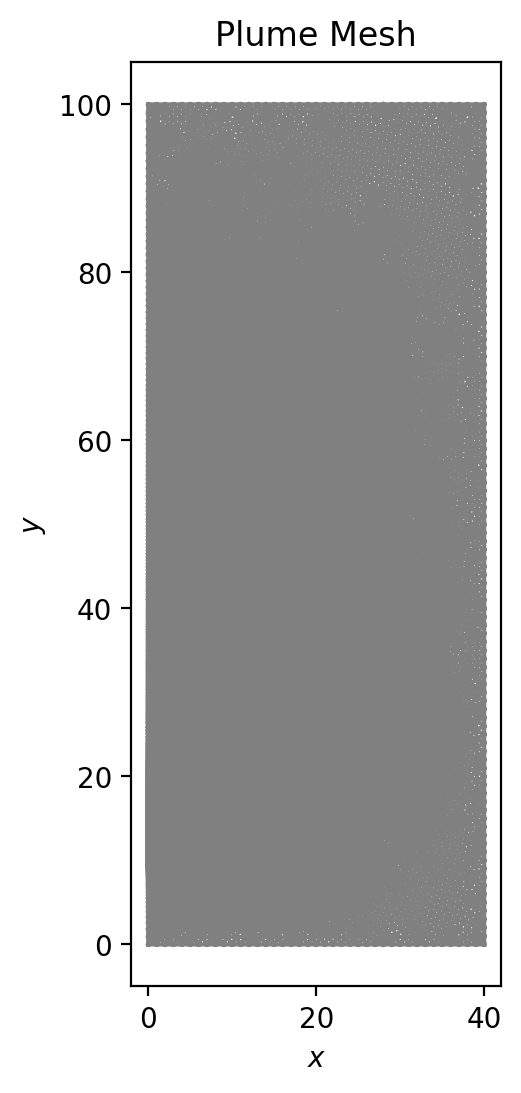

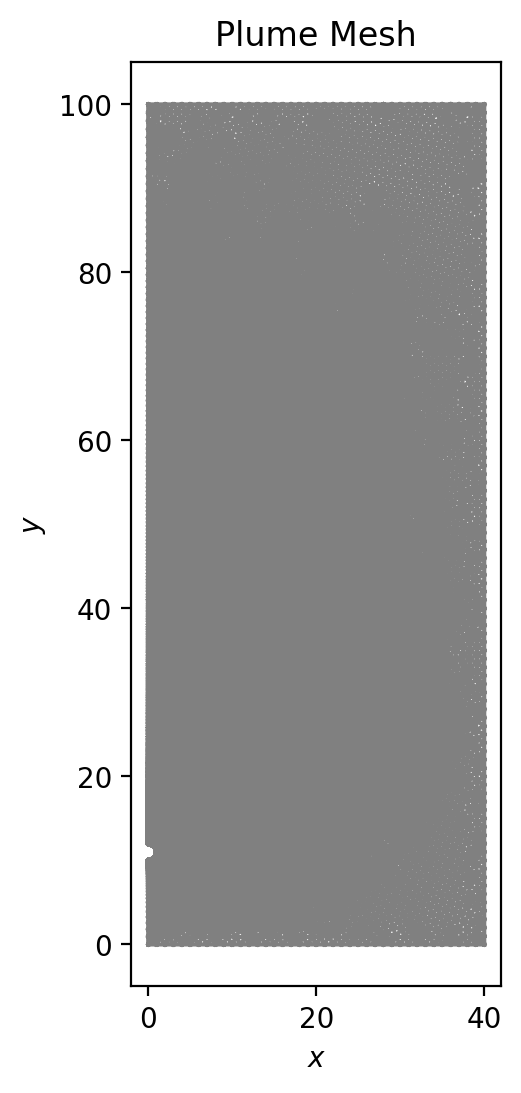

In [5]:
# generate_mesh(GEOM_FILE, MSH_FILE, TRIG_XDMF_PATH, FACETS_XDMF_PATH)
# generate_mesh(GEOM_FILE, MSH_FILE_C, TRIG_XDMF_PATH, FACETS_XDMF_PATH)
mesh, ct, ft, domains, dx, boundary_markers, mc, mf = read_mesh(TRIG_XDMF_PATH, FACETS_XDMF_PATH, MESH_NAME, PRINT_TAG_SUMMARY)
sub_mesh, sub_ft, sub_dx, sub_ds = create_submesh(mesh,mc,mf,AIR_TAG)
plot_mesh(mesh, title="Plume Mesh")
plot_mesh(sub_mesh, title="Plume Mesh")


## Variational problem for the wire heating to obtain initial guess for convection problem

Solving linear variational problem.
Solved heat equation on wire submesh. Output: data/abs/temperature.xdmf


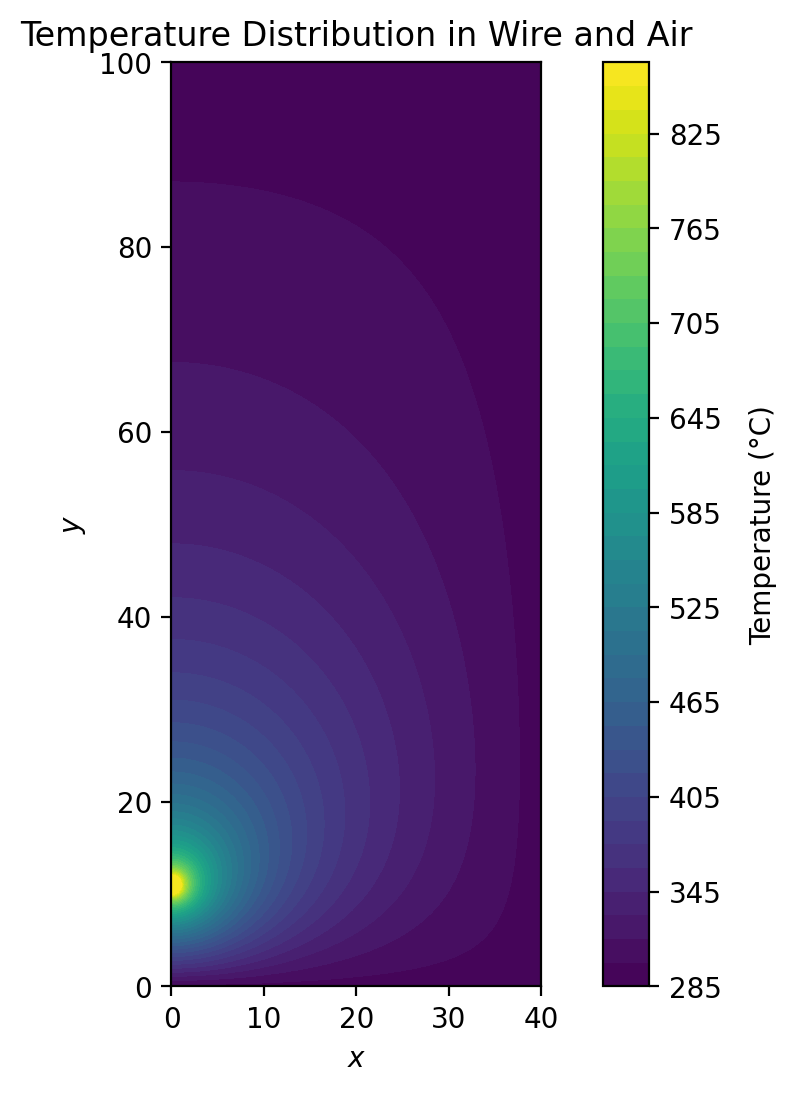

In [6]:
# -----------------------------------------
# Function spaces
# -----------------------------------------
V_T_full = fenics.FunctionSpace(mesh, "Lagrange", 1)

T = fenics.TrialFunction(V_T_full)
v = fenics.TestFunction(V_T_full)

# DG0 fields for k and q
V0 = fenics.FunctionSpace(mesh, "DG", 0)
k_func = fenics.Function(V0)
q_func = fenics.Function(V0)

# -----------------------------------------
# Fill cellwise values (using MeshFunction ct)
# -----------------------------------------
# ct: MeshFunction("size_t", mesh, mesh.topology().dim())
# ct.array() gives tag per cell in order of mesh.cells()

k_vals = np.full(mc.array().shape, k_air, dtype=float)
k_vals[mc.array() == WIRE_TAG] = k_wire

q_vals = np.full(mc.array().shape, q_air, dtype=float)
q_vals[mc.array() == WIRE_TAG] = q_wire
# Assign into DG0 functions
k_func.vector()[:] = k_vals
q_func.vector()[:] = q_vals

# -----------------------------------------
# Boundary data
# -----------------------------------------
T_inf = fenics.Constant(T_ambient)
h     = fenics.Constant(h_conv)

# -----------------------------------------
# Measures
# -----------------------------------------
dx = fenics.Measure("dx", domain=mesh, subdomain_data=mc)
ds = fenics.Measure("ds", domain=mesh, subdomain_data=mf)   # mf = MeshFunction for facets

# -----------------------------------------
# Weak form
# -----------------------------------------
a_T = (k_func * inner(grad(T), grad(v))) * dx \
      + h * T * v * ds(OUTER_AIR_TAG)

L_T = (q_func * v) * dx \
      + h * T_inf * v * ds(OUTER_AIR_TAG)

# -----------------------------------------
# Optional: no Dirichlet BCs
# -----------------------------------------
bcs_T = []

# -----------------------------------------
# Solve
# -----------------------------------------
T_full = fenics.Function(V_T_full)
fenics.solve(a_T == L_T, T_full, bcs_T,
      solver_parameters={
          "linear_solver": "lu"
      })

T_full.rename("T_conduction_full", "")

# -----------------------------------------
# Save result
# -----------------------------------------
save_experiment(OUTPUT_XDMF_PATH_TEMP, mesh, [T_full])
plot_mesh(T_full, title="Temperature Distribution in Wire and Air", cmap = "coolwarm", colorbar=True)

# -----------------------------------------
# preparing for flux continuity
# -----------------------------------------
Vg = fenics.VectorFunctionSpace(mesh, "DG", 0)
gradT_DG0 = fenics.project(grad(T_full), Vg)   # T_full from your conduction solve

wire_mesh = fenics.SubMesh(mesh, mc, WIRE_TAG)
bbt_wire = fenics.BoundingBoxTree()
bbt_wire.build(wire_mesh)

V0_air = FunctionSpace(sub_mesh, "DG", 0)
qn_air = Function(V0_air)
qn_air.vector().zero()

# To average if a cell touches the interface via multiple facets
counts = qn_air.vector().copy()
counts.zero()

tdim = sub_mesh.topology().dim()
sub_mesh.init(tdim-1, tdim)
mesh.init(tdim-1, tdim)

n_eps = 1e-10  # will be scaled below (we’ll improve this using h)

# A small shift distance into the wire, based on local mesh size
h_air = CellDiameter(sub_mesh)

for f in facets(sub_mesh):
    if sub_ft[f] != INTERFACE_TAG:
        continue

    c_air = list(cells(f))[0]
    c_air_idx = c_air.index()

    # Air outward normal on this interface facet (points from air to wire if your submesh is air-only)
    n_air = f.normal().array()
    n_air /= np.linalg.norm(n_air)

    x = f.midpoint().array()

    # Shift slightly into the wire side to avoid ambiguity exactly on the interface
    # Use a tiny length scale based on air cell diameter
    eps = 1e-6 * float(c_air.circumradius())
    x_in_wire = x + eps * n_air  # outward from air

    # Find which wire cell contains this shifted point
    # (returns (cell_id, distance); if not found, it may return a large distance)
    cid = bbt_wire.compute_first_entity_collision(Point(*x_in_wire))

    if cid < 0:
        # If normal orientation is opposite, try the other side
        x_in_wire = x - eps * n_air
        cid = bbt_wire.compute_first_entity_collision(Point(*x_in_wire))
        if cid < 0:
            continue  # give up on this facet

    c_wire = Cell(wire_mesh, cid)

    # Map wire submesh cell back to parent mesh cell index
    parent_wire = wire_mesh.data().array("parent_cell_indices", mesh.topology().dim())
    parent_cid = int(parent_wire[c_wire.index()])
    c_parent = Cell(mesh, parent_cid)

    # Evaluate cellwise grad(T) and k in that parent cell (DG0 values)
    gT = gradT_DG0(c_parent.midpoint())
    k_w = k_func(c_parent.midpoint())

    qn = -k_w * (gT[0]*n_air[0] + gT[1]*n_air[1])

    # Accumulate into the adjacent air cell (DG0)
    qn_air.vector()[c_air_idx] += qn
    counts[c_air_idx] += 1.0

# Average per cell
qn_air.vector()[:] = qn_air.vector().get_local() / np.maximum(counts.get_local(), 1.0)


In [7]:
P1 = fenics.FiniteElement('P', sub_mesh.ufl_cell(), 1)
P2 = fenics.VectorElement('P', sub_mesh.ufl_cell(), 2)
mixed_element = fenics.MixedElement([P1, P2, P1])
W = fenics.FunctionSpace(sub_mesh, mixed_element)

psi_p, psi_u, psi_T = fenics.TestFunctions(W)

w = fenics.Function(W)
p, u, T = fenics.split(w)


Getting the surface temperature for the interface

### Benchmark parameters
Set constant dynamic viscosity, Prandtl number, and Rayleigh number for the natural convection benchmark in [5]. For each we define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

Define the idealized linear Boussinesq buoyancy, scaled according to [5],

\begin{align*}
\mathbf{f}_B(T) = \frac{\mathrm{Ra}}{\mathrm{Pr}} T\begin{pmatrix} 0 \\ -1 \end{pmatrix}.
\end{align*}

Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively.

Object cannot be plotted directly, projecting to piecewise linears.


Text(0, 0.5, '$y$')

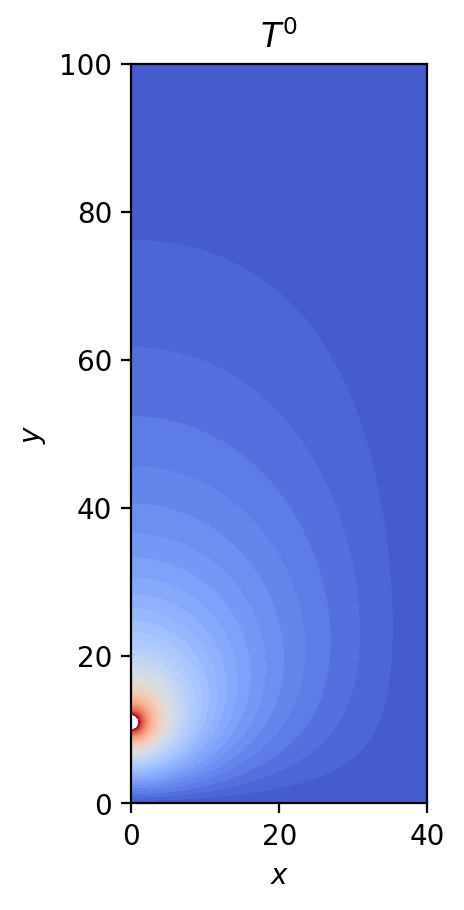

In [8]:
# dynamic_viscosity = 1.

# mu = fenics.Constant(dynamic_viscosity)

# prandtl_number = 0.71

# Pr = fenics.Constant(prandtl_number)

# rayleigh_number = 10

# Ra = fenics.Constant(rayleigh_number)

# f_B = Ra/Pr*T*fenics.Constant((0., -1.))

L_ref = D_wire/2.0  # characteristic length (m)
DeltaT = float(T_full.vector().max() - T_ambient)
T_ref  = T_ambient

nu    = mu_air / rho_air            # kinematic viscosity
alpha = k_air   / (rho_air*cp_air)  # thermal diffusivity

Gr_val  = g * beta_air * DeltaT * L_ref**3 / nu**2
Pr_val  = nu / alpha

# For now: treat Ec/ε as a user parameter (you can refine later)
Ecf_val = 4.0e-4  # <-- choose / tune this

from math import sqrt
sqrt_Gr = sqrt(Gr_val)

Pr  = fenics.Constant(Pr_val)
Gr  = fenics.Constant(Gr_val)
Ecf = fenics.Constant(Ecf_val)

# viscosity prefactor 1/sqrt(Gr) in ABE momentum equation
mu = fenics.Constant(1.0/sqrt_Gr)

# dimensionless gravity (downward y)
g_vec = fenics.Constant((0.0, -1.0))

# buoyancy: -θ g  (T is θ in the ABE system)
f_B = -T * g_vec

VTa = fenics.FunctionSpace(sub_mesh, "CG", 1)
T_air_bc = fenics.Function(VTa)
T_air_bc.interpolate(T_full)
# hot_wall_temperature = float(T_air_bc.vector().max())

hot_wall_temperature = 1.0
T_h = fenics.Constant(hot_wall_temperature)

cold_wall_temperature = 0.0

T_c = fenics.Constant(cold_wall_temperature)

# w_n = fenics.interpolate(
#     fenics.Expression(("0.", "0.", "0.", "T_full"), 
#                       T_full = T_full,
#                       element = mixed_element),
#                         W)

DeltaT = float(T_air_bc.vector().max() - T_ambient)  # crude example
theta_full = fenics.project((T_full - T_ambient)/DeltaT, V_T_full)
theta_full.rename("theta_full", "")

q_theta = (qn_air * L_ref) / (k_air * DeltaT)


w_n = fenics.interpolate(
    fenics.Expression(("0.", "0.", "0.", "theta_full"),
                      theta_full=theta_full,
                      element=mixed_element),
    W)


p_n, u_n, T_n = fenics.split(w_n)
fenics.plot(T_n)

plt.title("$T^0$")

plt.xlabel("$x$")

plt.ylabel("$y$")


## Nonlinear variational form

We can write the nonlinear system of equations as

\begin{align*}
\mathbf{F}(\mathbf{w}) = \mathbf{0}
\end{align*}

To obtain the finite element weak form, we follow the standard Ritz-Galerkin method extended for mixed finite elements. Therefore, we multiply the system  *from the left* by test functions $\boldsymbol{\psi}$ from the mixed finite element function space $\mathbf{W}$ and integrate over the spatial domain $\Omega$. This gives us the variational problem: Find $\mathbf{w} \in \mathbf{W}$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = \int_\Omega 
    \boldsymbol{\psi}^\mathrm{T} \mathbf{F}(\mathbf{w}) 
    d\mathbf{x} = 0 \quad \forall \boldsymbol{\psi} \in \mathbf{W}
\end{align*}

Integrating $\mathcal{F}$ by parts yields
 
\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = -(\psi_p,\nabla\cdot\mathbf{u}) \\
    + (\boldsymbol{\psi}_u, \mathbf{u}_t + \nabla\mathbf{u}\cdot\mathbf{u} + \mathbf{f}_B(T)) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathbf{D}(\boldsymbol{\psi}_u),\mathbf{D}(\mathbf{u})) \\
    + (\psi_T,T_t) + (\nabla \psi_T, \frac{1}{\mathrm{Pr}}\nabla T - T\mathbf{u})
\end{align*}

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|

Define the nonlinear variational form $\mathcal{F}$.

We add a penalty method stabilization term $-\gamma(\psi_p,p)$, setting the stabilization parameter $\gamma = 10^{-7}$ as done in [5].

|Note|
|----|
|One can solve the incompressible Navier-Stokes equation **either** with P2P1 elements, **or** with the penalty method and P1P1 elements. Neither of these approaches works alone when also coupling the temperature convection-diffusion equation with Boussinesq buoyancy; but applying both stabilization methods together does work.|

In [9]:
# Time stepping
timestep_size = 0.001
Delta_t = fenics.Constant(timestep_size)

u_t = (u - u_n)/Delta_t
T_t = (T - T_n)/Delta_t

inner, dot, grad, div, sym = fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym

mass = -psi_p*div(u)

momentum = dot(psi_u, u_t + dot(grad(u), u) + f_B) \
           - div(psi_u)*p \
           + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))

# thermal diffusion coefficient 1/(Pr * sqrt(Gr)) using numeric values
k_eff = 1.0/(Pr_val * sqrt_Gr)

energy = (
    psi_T*T_t
    + dot(grad(psi_T), k_eff*grad(T) - T*u)
    + psi_T * Ecf * dot(g_vec, u)
)

F = (mass + momentum + energy)*sub_dx
# F = (mass + momentum + energy)*fenics.dx

gamma = fenics.Constant(1.e-7)
# F += -psi_p*gamma*p*fenics.dx
F += -psi_p*gamma*p*sub_dx
F += k_eff*q_theta * psi_T * sub_ds(INTERFACE_TAG)
# F += (1.0 / (Pr_val * sqrt_Gr)) * q_theta * psi_T * sub_ds(INTERFACE_TAG)



## Linearization

Notice that $\mathcal{F}$ is a *nonlinear* variational form. FEniCS will solve the nonlinear problem using Newton's method. This requires computing the Jacobian (formally the Gâteaux derivative) of the nonlinear variational form, yielding a a sequence of linearized problems whose solutions may converge to approximate the nonlinear solution.

We could manually define the Jacobian; but thankfully FEniCS can do this for us.

In [10]:
JF = fenics.derivative(F, w, fenics.TrialFunction(W))


|Note|
|----|
|When solving linear variational problems in FEniCS, one defines the linear variational form using `fenics.TrialFunction` instead of `fenics.Function` (while both approaches will need `fenics.TestFunction`). When solving nonlinear variational problems with FEniCS, we only need `fenics.TrialFunction` to define the linearized problem, since it is the linearized problem which will be assembled into a linear system and solved.|

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational *problem* (i.e. in this case a boundary value problem).

We physically consider *no slip* velocity boundary conditions for all boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    T(\mathbf{x}) &= 
    \begin{cases}
        T_h , && x_0 = 0 \\
        T_c , && x_0 = 1 
    \end{cases}
\end{align*}

In [11]:
# python class 

class Hot_wall(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near((x[0]**2)+((x[1]-11.)**2)-1., 0., eps= 1.e-1) and x[1] >= 10. and x[1] <= 12.
# hot_wall = " near((x[0]*x[0])+((x[1]-11.)*(x[1]-11.))-1., 0.)"
hot_wall=Hot_wall()

cold_wall = "near(x[0],  1.) | near(x[1], 0.) | near(x[1], 1.)"

adiabatic_walls = "near(x[0],  0.)"

# walls = hot_wall + " | " + cold_wall + " | " + adiabatic_walls

W_u = W.sub(1)

W_T = W.sub(2)

boundary_conditions = [
    fenics.DirichletBC(W_u, (0., 0.), hot_wall),
    # fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall),
    # fenics.DirichletBC(W_T,T_air_bc,sub_ft,INTERFACE_TAG),
    fenics.DirichletBC(W_T, cold_wall_temperature, cold_wall)]


## Nonlinear variational problem

Now we have everything we need to define the variational problem.

In [12]:
w.leaf_node().vector()[:] = w_n.leaf_node().vector()
problem = fenics.NonlinearVariationalProblem(F, w, boundary_conditions, JF)

solver = fenics.NonlinearVariationalSolver(problem)
solver.solve()


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.627e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.520e-08 (tol = 1.000e-10) r (rel) = 4.007e-08 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.710e-14 (tol = 1.000e-10) r (rel) = 5.967e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.


(2, True)

In [13]:
V0_air = FunctionSpace(sub_mesh, "DG", 0)

h_eff_air = Function(V0_air, name="h_eff_air")
Bi_air    = Function(V0_air, name="Bi_air")

h_eff_air.vector().zero()
Bi_air.vector().zero()

counts = h_eff_air.vector().copy()
counts.zero()

T_inf = float(T_ambient)
k_wire_val = k_wire
Lc = D_wire/2  # R/2 with R=1
tol = 1e-12

for f in fenics.facets(sub_mesh):
    if sub_ft[f] != INTERFACE_TAG:
        continue

    c_air = list(fenics.cells(f))[0]
    idx = c_air.index()

    x = f.midpoint().array()

    # Surface temperature (from conduction trace or air solution)
    Ts = T_full(fenics.Point(*x))      # preferred: solid-side temperature
    # Ts = T(Point(*x))         # alternative: air-side temperature

    dT = Ts - T_inf
    if abs(dT) < tol:
        continue

    q = qn_air.vector()[idx]

    h_eff = q / dT
    Bi = h_eff * Lc / k_wire_val

    h_eff_air.vector()[idx] += h_eff
    Bi_air.vector()[idx]    += Bi
    counts[idx] += 1.0

counts_arr = counts.get_local()
counts_arr[counts_arr == 0.0] = 1.0

h_eff_air.vector()[:] /= counts_arr
Bi_air.vector()[:]    /= counts_arr

print(set(Bi_air.vector()))

save_experiment(
    "data/abs/air_biot.xdmf",
    sub_mesh,
    [h_eff_air, Bi_air]
)


{0.0, -2.10110893483771e-05, -2.124365129496393e-05, -2.102305243311626e-05, -1.8534961781385107e-05, -1.8373902350697755e-05, -1.890061950325693e-05, -1.858302437616528e-05, -2.0710079049889627e-05, -1.951891617133009e-05, -1.8903992413191625e-05, -2.1534246922492853e-05, -1.9899965705469873e-05, -1.8554824445755706e-05, -2.0568229955625925e-05, -2.1379817227678754e-05, -1.8378745727036345e-05, -1.8981839697353798e-05, -1.833285429593433e-05, -1.8337061034003095e-05, -2.0749934020748444e-05, -2.1299813637253913e-05, -1.8518441534840924e-05, -1.9031419095710787e-05, -1.8326787631422323e-05, -2.0150961935477336e-05, -2.0677785203150155e-05, -2.0560320227623447e-05, -1.8321445269306574e-05, -2.1455680178243756e-05, -1.88902663271104e-05, -2.062929406936353e-05, -2.000433566700027e-05, -1.8347361759583497e-05, -1.933831241977311e-05, -1.8362724347223896e-05, -2.1214966742380085e-05, -2.1498170538793468e-05, -1.8489036591440942e-05, -1.9139084991435857e-05, -2.0587784083679407e-05, -2.1563

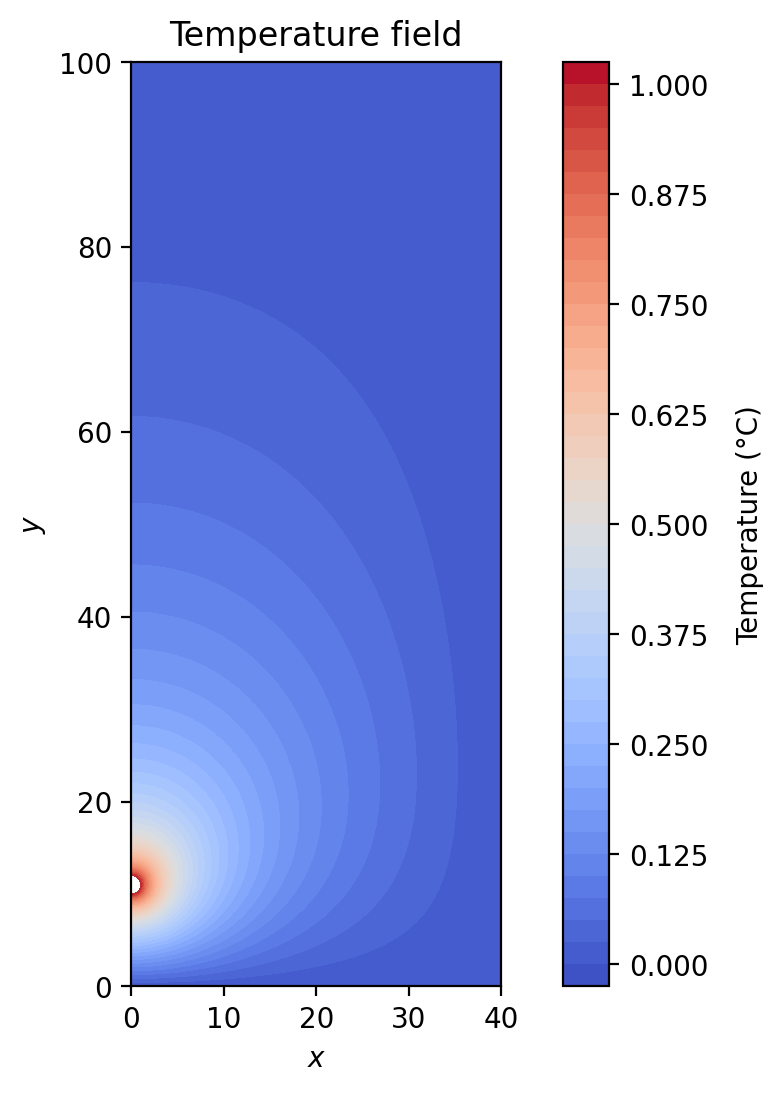

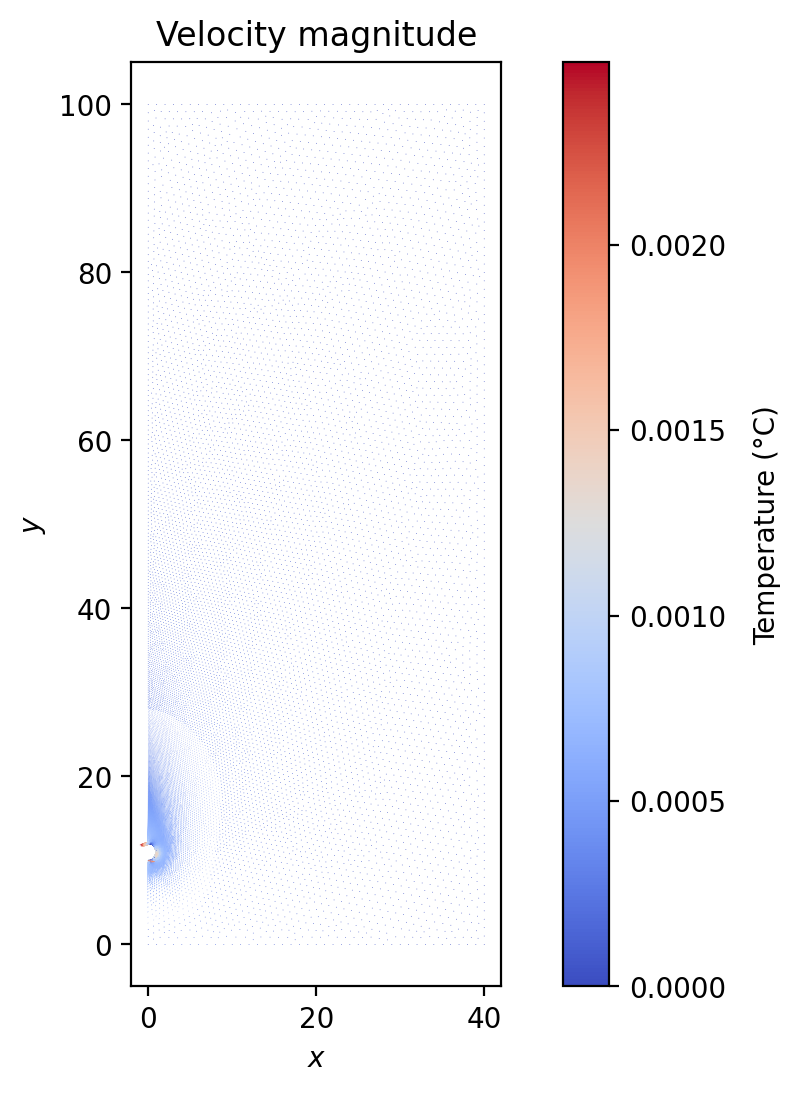

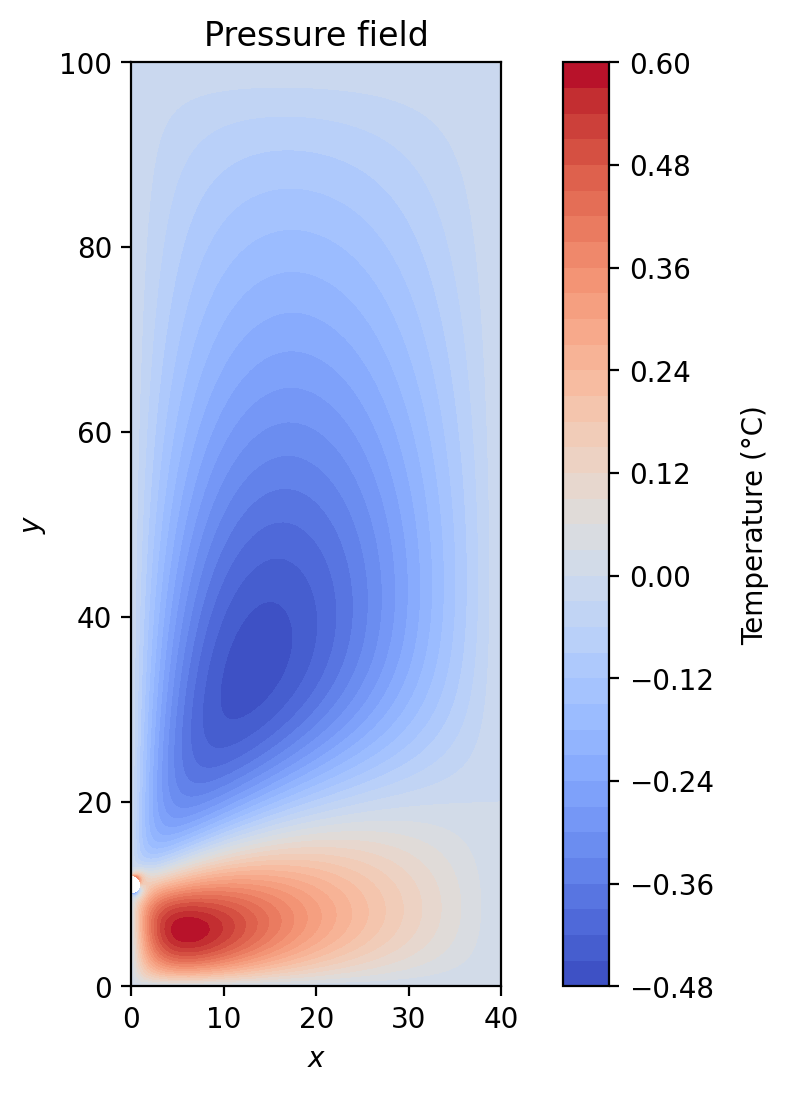

<class 'dolfin.function.function.Function'>
Solved heat equation on wire submesh. Output: data/abs/air_pressure.xdmf
Solved heat equation on wire submesh. Output: data/abs/air_velocity.xdmf
Solved heat equation on wire submesh. Output: data/abs/air_temperature.xdmf
Solved heat equation on wire submesh. Output: data/abs/air_pvt.xdmf


In [14]:
from matplotlib import interactive
interactive(True)

p, u , T = fenics.split(w.leaf_node())

p, u, T = w.split()

plot_mesh(T, title="Temperature field", cmap = "coolwarm", colorbar=True)
plot_mesh(u, title="Velocity magnitude", cmap = "coolwarm", colorbar=True, mode="glyphs")
plot_mesh(p, title="Pressure field", cmap = "coolwarm", colorbar=True)

print(type(w.split()[0]))  # <class 'dolfin.function.function.Function'>
save_experiment(OUTPUT_XDMF_PATH_AIR_P, sub_mesh, [p])
save_experiment(OUTPUT_XDMF_PATH_AIR_V, sub_mesh, [u])
save_experiment(OUTPUT_XDMF_PATH_AIR_T, sub_mesh, [T])
save_experiment(OUTPUT_XDMF_PATH_AIR_PVT, sub_mesh, [p,u,T])
